### Importing Libraries

In [31]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import random
from datetime import datetime
import seaborn as sns

from sklearn.model_selection import train_test_split

### Loading Data

In [32]:
data_path = r"C:/Users/divyas/Documents/hackathons/CMI_PB/Tasks/Task_IGg_PT/Data_Task_IGg_PT/"

X_train = pd.read_csv(data_path + "abtiter_data_X_train.csv", index_col=0)
y_train = pd.read_csv(data_path + "abtiter_data_y_train.csv", index_col=0)
X_test = pd.read_csv(data_path + "abtiter_data_X_test.csv", index_col=0)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")


X_train shape: (111, 42)
y_train shape: (111, 1)
X_test shape: (54, 42)


In [33]:
X_train.head()

,IgG_PRN,IgG_FHA,IgG1_PT,IgG1_PRN,IgG1_FHA,IgG1_FIM2/3,IgG1_TT,IgG1_DT,IgG1_OVA,IgG2_PT,...,specimen_type,visit,infancy_vac,biological_sex,ethnicity,race,year_of_birth,date_of_boost,dataset,timepoint
subject_id,,,,,,,,,,,,,,,,,,,,,
1,2.602350,34.050956,7.334714,2.174783,3.013252,1.188744,1.428852,2.389153,0.665203,1.000000,...,Blood,1,wP,Female,Not Hispanic or Latino,White,1986-01-01,2016-09-12,2020_dataset,0
3,7.652635,1.096457,1.424098,3.161591,1.287515,0.322658,1.377390,1.523941,33.771912,1.000000,...,Blood,1,wP,Female,Unknown,White,1983-01-01,2016-10-10,2020_dataset,0
4,5.670403,1.048276,3.888604,2.591155,1.269821,2.621216,1.675259,2.022924,5.777047,4.269877,...,Blood,1,wP,Male,Not Hispanic or Latino,Asian,1988-01-01,2016-08-29,2020_dataset,0
5,5.268274,0.084437,7.456313,2.760065,2.864834,7.487345,1.537432,2.250237,4.130732,6.070427,...,Blood,1,wP,Male,Not Hispanic or Latino,Asian,1991-01-01,2016-08-29,2020_dataset,0
6,0.090176,0.379290,0.084132,0.025479,0.654192,0.681225,0.874920,0.369367,10.452881,1.000000,...,Blood,1,wP,Female,Not Hispanic or Latino,White,1988-01-01,2016-10-10,2020_dataset,0


In [34]:
X_test.head()

,IgG_PRN,IgG_FHA,IgG1_PT,IgG1_PRN,IgG1_FHA,IgG1_FIM2/3,IgG1_TT,IgG1_DT,IgG1_OVA,IgG2_PT,...,specimen_type,visit,infancy_vac,biological_sex,ethnicity,race,year_of_birth,date_of_boost,dataset,timepoint
subject_id,,,,,,,,,,,,,,,,,,,,,
142,0.066482,0.102288,0.452381,1.343446,0.637104,1.250859,0.137712,0.252301,0.215054,0.419355,...,Blood,3,aP,Female,Not Hispanic or Latino,Asian,1991-01-01,2022-11-28,2023_dataset,0
146,3.039959,2.687800,27.488095,3.248061,2.481587,0.508973,0.056218,0.830831,0.309677,0.709677,...,Blood,3,wP,Male,Not Hispanic or Latino,Black or African American,1992-01-01,2023-01-03,2023_dataset,0
163,0.052871,0.002726,0.510791,0.025011,0.010421,0.008366,0.291480,0.334586,0.395062,0.666667,...,Blood,3,wP,Female,Not Hispanic or Latino,White,1993-01-01,2023-07-24,2023_dataset,0
124,1.053969,0.299007,1.416667,0.911267,0.298782,0.068729,0.525460,1.147328,0.572043,0.870968,...,Blood,3,aP,Male,Hispanic or Latino,Unknown or Not Reported,2000-01-01,2022-03-07,2023_dataset,0
134,1.344032,0.987074,0.904762,1.208517,1.225409,1.037801,2.272647,1.163639,1.668817,1.032258,...,Blood,3,wP,Male,Not Hispanic or Latino,More Than One Race,1990-01-01,2022-05-31,2023_dataset,0


### Data Preprocessing

In [35]:
# Convert 'date_of_boost' and 'year_of_birth' to datetime format for both training and test sets
X_train['date_of_boost'] = pd.to_datetime(X_train['date_of_boost'], errors='coerce')
X_test['date_of_boost'] = pd.to_datetime(X_test['date_of_boost'], errors='coerce')
X_train['year_of_birth'] = pd.to_datetime(X_train['year_of_birth'], format='%Y-%m-%d', errors='coerce')
X_test['year_of_birth'] = pd.to_datetime(X_test['year_of_birth'], format='%Y-%m-%d', errors='coerce')

# Function to calculate 'age' based on 'year_of_birth' and 'date_of_boost'
def calculate_age(row):
    if pd.notnull(row['year_of_birth']) and pd.notnull(row['date_of_boost']):
        return row['date_of_boost'].year - row['year_of_birth'].year
    return None  # Handle missing values gracefully

# Calculate 'age' for training and test datasets
X_train['age'] = X_train.apply(calculate_age, axis=1)
X_test['age'] = X_test.apply(calculate_age, axis=1)


# Map categorical columns and drop unnecessary columns
X_train['infancy_vac'] = X_train['infancy_vac'].map({'wP': 0, 'aP': 1})
X_train['biological_sex'] = X_train['biological_sex'].map({'Female': 0, 'Male': 1})
X_test['infancy_vac'] = X_test['infancy_vac'].map({'wP': 0, 'aP': 1})
X_test['biological_sex'] = X_test['biological_sex'].map({'Female': 0, 'Male': 1})

# Combine X_train and X_test for consistent encoding. We do this because some races in train are not available in test.
X_combined = pd.concat([X_train, X_test], axis=0)

# Perform one-hot encoding on 'race' across the entire dataset
X_combined = pd.get_dummies(X_combined, columns=['race'], drop_first=False)

# Separate back into training and test sets based on their original indices
X_train_new = X_combined.loc[X_train.index]
X_test_new = X_combined.loc[X_test.index]

# Drop metadata columns not required for training and testing
metadata_columns = ['dataset', 'timepoint', 'date_of_boost', 'year_of_birth', 'ethnicity', 'visit', 'specimen_type']
X_train_new = X_train_new.drop(columns=metadata_columns, errors='ignore')
X_test_new = X_test_new.drop(columns=metadata_columns, errors='ignore')

# Print processed data for verification
print("X_train after processing:", X_train_new.head())
print("X_test after processing:", X_test_new.head())


# Standardize the dataset (fit only on training data)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_new)
X_test_scaled = scaler.transform(X_test_new)

# # Convert to tensor format
# X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
# X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)


X_train after processing:              IgG_PRN    IgG_FHA   IgG1_PT  IgG1_PRN  IgG1_FHA  IgG1_FIM2/3  \
subject_id                                                                   
1           2.602350  34.050956  7.334714  2.174783  3.013252     1.188744   
3           7.652635   1.096457  1.424098  3.161591  1.287515     0.322658   
4           5.670403   1.048276  3.888604  2.591155  1.269821     2.621216   
5           5.268274   0.084437  7.456313  2.760065  2.864834     7.487345   
6           0.090176   0.379290  0.084132  0.025479  0.654192     0.681225   

             IgG1_TT   IgG1_DT   IgG1_OVA   IgG2_PT  ...  infancy_vac  \
subject_id                                           ...                
1           1.428852  2.389153   0.665203  1.000000  ...            0   
3           1.377390  1.523941  33.771912  1.000000  ...            0   
4           1.675259  2.022924   5.777047  4.269877  ...            0   
5           1.537432  2.250237   4.130732  6.070427  ...      

### Seeing Age Distribution

In [36]:
# # import matplotlib.pyplot as plt

# # Plot age distribution for both training and test sets
# plt.figure(figsize=(12, 6))
# plt.hist(X_train['age'], bins=20, alpha=0.6, label="Training Set", color="skyblue")
# plt.hist(X_test['age'], bins=20, alpha=0.6, label="Test Set", color="salmon")
# plt.xlabel("Age")
# plt.ylabel("Frequency")
# plt.title("Age Distribution in Training and Test Sets")
# plt.legend()
# plt.show()


In [37]:
# # Calculating the minimum and maximum ages in the train dataset to define appropriate age bins
# min_age_train = X_train['age'].min()
# max_age_train = X_train['age'].max()
# min_age_train, max_age_train


In [38]:
# # Calculating the minimum and maximum ages in the dataset to define appropriate age bins
# min_age_test = X_test['age'].min()
# max_age_test = X_test['age'].max()
# min_age_train, max_age_train


In [39]:
# # Define age bins (you can adjust the bins based on your data distribution)
# age_bins = [0, 20, 30, 40, 50]
# age_labels = ['0-20', '21-30', '31-40', '41-50']

# # Temporarily add an 'age_group' column to X_train for visualization purposes
# temp_X_train = X_train_new.copy()
# temp_X_train['age_group'] = pd.cut(temp_X_train['age'], bins=age_bins, labels=age_labels)

# # Combine `temp_X_train` with `y_train` for visualization without modifying original data
# data_for_plot = temp_X_train.join(y_train)

# # Box plot of immune response (IgG_PT) across different age groups
# plt.figure(figsize=(12, 6))
# sns.boxplot(x='age_group', y='IgG_PT', data=data_for_plot, palette="coolwarm")
# plt.xlabel("Age Group")
# plt.ylabel("Immune Response (IgG_PT)")
# plt.title("Immune Response Distribution Across Age Groups")

# # Save the plot as an image file
# plt.savefig("C:/Users/divyas/Documents/hackathons/CMI_PB/Tasks/Task_IGg_PT/Results/immune_response_age_groups.png", dpi=300, bbox_inches='tight')  # Change the file path as needed
# plt.show()

# # Calculate and display the correlation between age and immune response
# age_immune_corr = data_for_plot[['age', 'IgG_PT']].corr().iloc[0, 1]
# print(f"Correlation between Age and Immune Response (IgG_PT): {age_immune_corr:.4f}")


In [40]:
# # Compute correlation matrix
# correlation_matrix = X_train_new.join(y_train).corr()

# # Focus on correlations with the immune response variable (y_train)
# response_corr = correlation_matrix['IgG_PT'].sort_values(ascending=False)

# # Plot correlations with features on the y-axis
# plt.figure(figsize=(8, 12))
# sns.barplot(x=response_corr.values, y=response_corr.index, palette="viridis")
# plt.xlabel("Correlation with Immune Response (IgG_PT)")
# plt.ylabel("Features")
# plt.title("Feature Correlation with Immune Response (IgG_PT)")
# plt.show()


In [41]:

# Set a fixed seed for reproducibility
seed = 42

# Python's built-in random module
random.seed(seed)

# NumPy random generator
np.random.seed(seed)

# PyTorch random generator for CPU
torch.manual_seed(seed)

# PyTorch random generator for GPU (if using CUDA)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Ensures deterministic behavior for certain CUDA operations (optional)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


### Defining Sparse Autoencoder Model

In [42]:
class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, sparsity_weight=10): ###sparsity_weight= hyperparameter
        super(SparseAutoencoder, self).__init__()
        self.encoder = nn.Linear(input_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, input_dim)
        self.sparsity_weight = sparsity_weight

    def forward(self, x):
        encoded = F.relu(self.encoder(x))
        decoded = self.decoder(encoded)
        return decoded, encoded

    def sparsity_loss(self, encoded):
        return self.sparsity_weight * torch.mean(torch.abs(encoded))


## Split training data into train and validation sets

In [43]:
# Split your data
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_scaled, y_train, test_size=0.1, random_state=42
)

# X_train_split.shape
# X_val_split.shape
# y_train_split.type()
# y_val_split.shape

# Convert the split data into tensors
X_train_tensor = torch.tensor(X_train_split, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_split, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_split.to_numpy(), dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_split.to_numpy(), dtype=torch.float32)

# Set up DataLoaders
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
x=next(iter(train_loader))
# print(x[1].shape)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



In [44]:
X_train_tensor.shape[1]

42

### Training sparse Autoencoder

In [45]:
# input_dim = X_train_scaled.shape[1]
# hidden_dim = 128 #hyperparameter
# sparsity_weight=10
# lr=1e-4
# model = SparseAutoencoder(input_dim=input_dim, hidden_dim=hidden_dim,sparsity_weight=sparsity_weight)
# optimizer = optim.Adam(model.parameters(), lr=lr)
# # lr=hyperparameter
# num_epochs = 500 

# train_losses = []
# val_losses=[]
# for epoch in range(num_epochs):
#     epoch_loss = 0.0
#     rec_loss=0.0
#     model.train()
#     for batch_data, _ in train_loader:
#         optimizer.zero_grad()
#         reconstructed, encoded = model(batch_data)
#         reconstruction_loss = F.mse_loss(reconstructed, batch_data)
        
#         sparsity_loss = model.sparsity_loss(encoded)
#         total_loss = reconstruction_loss + sparsity_loss
#         total_loss.backward()
#         optimizer.step()
#         epoch_loss += total_loss.item()
#         rec_loss+=reconstruction_loss
    
#     avg_epoch_loss = epoch_loss / len(train_loader.dataset)
    
#     avg_rec_loss=rec_loss/len(train_loader.dataset)
#     train_losses.append(avg_epoch_loss)
#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}")
#     print(f"Epoch [{epoch+1}/{num_epochs}], Reconstruction Loss: {avg_rec_loss:.4f}")
#     model.eval()
    
#     with torch.no_grad():
        
#         batch_loss=0.0
#         rec_loss=0.0
#         for batch_data, _ in val_loader:
            
#             reconstructed, encoded = model(batch_data)
#             reconstruction_loss = F.mse_loss(reconstructed, batch_data)
        
#             sparsity_loss = model.sparsity_loss(encoded)
#             total_loss = reconstruction_loss + sparsity_loss
#             batch_loss += total_loss.item()
#             rec_loss+=reconstruction_loss
#         avg_batch_loss = batch_loss / len(val_loader.dataset)
#         avg_rec_loss=rec_loss/len(val_loader.dataset)
#         val_losses.append(avg_batch_loss)
#     print(f"Val Loss: {avg_batch_loss:.4f}")
#     print(f"Val Reconstruction Loss: {avg_rec_loss:.4f}")




In [46]:
def train_sparse_autoencoder(model, train_loader, val_loader, optimizer, num_epochs=500, print_losses=False):
    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0

        for batch_data in train_loader:
            batch_data = batch_data[0]  # Extract the single tensor from batch tuple
            optimizer.zero_grad()
            reconstructed, encoded = model(batch_data)
            reconstruction_loss = F.mse_loss(reconstructed, batch_data)
            sparsity_loss = model.sparsity_loss(encoded)
            total_loss = reconstruction_loss + sparsity_loss
            total_loss.backward()
            optimizer.step()
            epoch_loss += total_loss.item()

        avg_epoch_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_epoch_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_data in val_loader:
                batch_data = batch_data[0]
                reconstructed, encoded = model(batch_data)
                reconstruction_loss = F.mse_loss(reconstructed, batch_data)
                sparsity_loss = model.sparsity_loss(encoded)
                val_loss += (reconstruction_loss + sparsity_loss).item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Print only if print_losses is True
        if print_losses:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    return train_losses, val_losses


In [47]:
# Initialize model and optimizer
input_dim = X_train_scaled.shape[1]
hidden_dim = 128
sparsity_weight = 10
lr = 1e-4

model = SparseAutoencoder(input_dim=input_dim, hidden_dim=hidden_dim, sparsity_weight=sparsity_weight)
optimizer = optim.Adam(model.parameters(), lr=lr)

# Train the model
train_losses, val_losses = train_sparse_autoencoder(model, train_loader, val_loader, optimizer, num_epochs=500,print_losses=True)


Epoch [1/500], Loss: 3.1602, Val Loss: 2.4651
Epoch [2/500], Loss: 3.2078, Val Loss: 2.4568
Epoch [3/500], Loss: 3.3328, Val Loss: 2.4496
Epoch [4/500], Loss: 3.9203, Val Loss: 2.4426
Epoch [5/500], Loss: 3.1116, Val Loss: 2.4366
Epoch [6/500], Loss: 3.1830, Val Loss: 2.4302
Epoch [7/500], Loss: 3.4962, Val Loss: 2.4237
Epoch [8/500], Loss: 3.3007, Val Loss: 2.4173
Epoch [9/500], Loss: 3.2126, Val Loss: 2.4109
Epoch [10/500], Loss: 3.1410, Val Loss: 2.4053
Epoch [11/500], Loss: 2.8260, Val Loss: 2.3996
Epoch [12/500], Loss: 3.1675, Val Loss: 2.3935
Epoch [13/500], Loss: 3.0276, Val Loss: 2.3871
Epoch [14/500], Loss: 3.0189, Val Loss: 2.3809
Epoch [15/500], Loss: 3.2585, Val Loss: 2.3747
Epoch [16/500], Loss: 2.7578, Val Loss: 2.3685
Epoch [17/500], Loss: 3.3495, Val Loss: 2.3624
Epoch [18/500], Loss: 2.8186, Val Loss: 2.3567
Epoch [19/500], Loss: 3.3103, Val Loss: 2.3508
Epoch [20/500], Loss: 2.8819, Val Loss: 2.3457
Epoch [21/500], Loss: 2.8247, Val Loss: 2.3403
Epoch [22/500], Loss: 

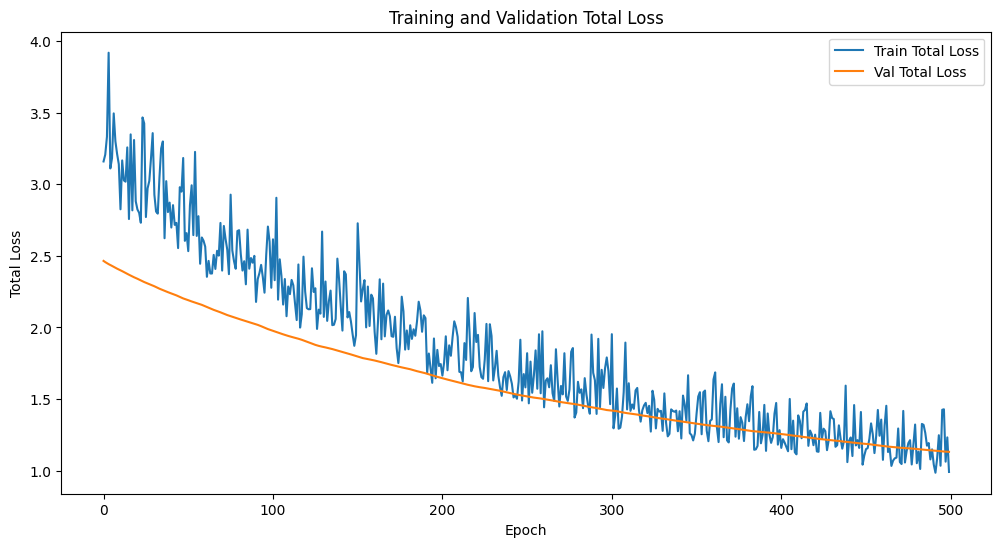

In [48]:
# Plotting the losses
plt.figure(figsize=(12, 6))

# Plot total loss
plt.plot(train_losses, label="Train Total Loss")
plt.plot(val_losses, label="Val Total Loss")
plt.xlabel("Epoch")
plt.ylabel("Total Loss")
plt.title("Training and Validation Total Loss")
plt.legend()
plt.show()

# # Plot reconstruction loss
# plt.figure(figsize=(12, 6))
# plt.plot(train_reconstruction_losses, label="Train Reconstruction Loss")
# plt.plot(val_reconstruction_losses, label="Val Reconstruction Loss")
# plt.xlabel("Epoch")
# plt.ylabel("Reconstruction Loss")
# plt.title("Training and Validation Reconstruction Loss")
# plt.legend()
# plt.show()


### Extracting Low-Dimensional Representation for Regression

In [49]:
model.eval()
with torch.no_grad():
    _, X_train_encoded = model(X_train_tensor)
    _, X_val_encoded = model(X_val_tensor)
    
X_train_encoded_np = X_train_encoded.numpy()
X_val_encoded_np = X_val_encoded.numpy()
y_train_np = y_train_tensor.numpy().ravel()
y_val_np=y_val_tensor.numpy().ravel()
# # Split encoded train data into training and validation sets for regression
# X_train_reg, X_val_reg = X_train_encoded_np[:train_size], X_train_encoded_np[train_size:]
# y_train_reg, y_val_reg = y_train_np[:train_size], y_train_np[train_size:]


### Training the Random Forest Regressor

In [50]:
# Initialize and train RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=500, random_state=42)
regressor.fit(X_train_encoded_np, y_train_np)

# Make predictions on validation set
y_pred_val = regressor.predict(X_val_encoded_np)
val_rmse = mean_squared_error(y_val_np, y_pred_val, squared=False)
print(f"Validation RMSE: {val_rmse:.4f}")

# Predict on test set if needed
y_pred_val = regressor.predict(X_val_encoded_np)


Validation RMSE: 4.1694


###  Plot Predicted vs Actual (for Validation Set)

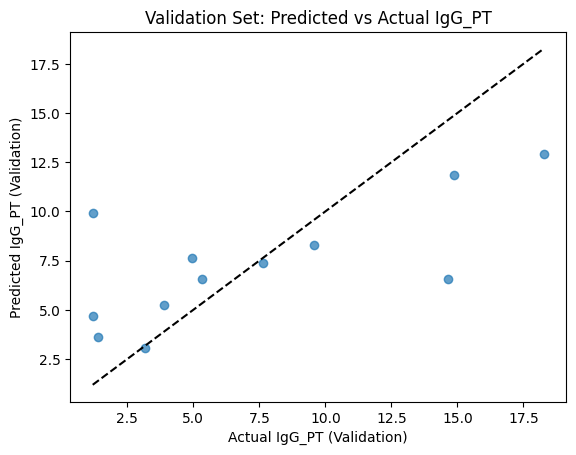

array([[1.        , 0.69975003],
       [0.69975003, 1.        ]])

In [51]:
plt.scatter(y_val_np, y_pred_val, alpha=0.7)
plt.xlabel("Actual IgG_PT (Validation)")
plt.ylabel("Predicted IgG_PT (Validation)")
plt.title("Validation Set: Predicted vs Actual IgG_PT")
plt.plot([y_val_np.min(), y_val_np.max()], [y_val_np.min(), y_val_np.max()], 'k--')
plt.show()
np.corrcoef(y_val_np, y_pred_val)

In [53]:
from scipy.stats import spearmanr

# Assuming y_true and y_pred are your true and predicted values as 1D arrays
# Replace these with your actual values
y_true = y_val_np  # e.g., y_train or y_test
y_pred = y_pred_val # e.g., model.predict(X_test)

# Calculate Spearman's rank correlation
spearman_corr, _ = spearmanr(y_true, y_pred)

print(f"Spearman's Rank Correlation Coefficient: {spearman_corr:.4f}")


Spearman's Rank Correlation Coefficient: 0.6364


In [54]:
# Assuming `y_true` and `y_pred` are numpy arrays or similar
def calculate_normalized_error_norm(y_true, y_pred):
    # Calculate the numerator: ||y_true - y_pred||
    error_norm = np.linalg.norm(y_true - y_pred)
    # Calculate the denominator: ||y_true||
    true_norm = np.linalg.norm(y_true)
    # Calculate the normalized error norm
    normalized_error_norm = error_norm / true_norm
    return normalized_error_norm

y_true = y_val_np  # e.g., y_train or y_test
y_pred = y_pred_val # e.g., model.predict(X_test)

normalized_error = calculate_normalized_error_norm(y_true, y_pred)  # Replace with actual data
print(f"Normalized Error Norm: {normalized_error:.4f}")



Normalized Error Norm: 0.4563


### Retraining on the whole training set and generating predictions for test.

In [55]:
# Convert the split data into tensors
X_train_final_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_final_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.float32)  # y_train should be a DataFrame or Series
# y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32)

# Set up DataLoaders
batch_size = 32
train_final_dataset = TensorDataset(X_train_final_tensor, y_train_final_tensor)
test_dataset = TensorDataset(X_test_tensor)

train_final_loader = DataLoader(train_final_dataset, batch_size=batch_size, shuffle=True)
x=next(iter(train_final_loader))
# print(x[1].shape)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Initialize and Train the Model on the Full Training Set

In [56]:
# Hyperparameters
input_dim = X_train_scaled.shape[1]
hidden_dim = 128
sparsity_weight = 10
lr = 1e-4
num_epochs = 500

# Initialize the model and optimizer
model = SparseAutoencoder(input_dim=input_dim, hidden_dim=hidden_dim, sparsity_weight=sparsity_weight)
optimizer = optim.Adam(model.parameters(), lr=lr)

# Train the autoencoder on the full training set
train_losses, _ = train_sparse_autoencoder(model, train_final_loader, train_final_loader, optimizer, num_epochs=num_epochs,print_losses=False)


## Generate Embeddings for Test Set and Train RandomForest

In [57]:
# Set the model to evaluation mode
model.eval()
with torch.no_grad():
    # Get embeddings for the full training set
    _, X_train_encoded = model(X_train_final_tensor)
    X_train_encoded_np = X_train_encoded.numpy()
    y_train_np = y_train_final_tensor.numpy().ravel()
    
    # Get embeddings for the test set
    test_embeddings = []
    for batch_data in test_loader:
        batch_data = batch_data[0]  # Unpack the single tensor
        _, encoded = model(batch_data)
        test_embeddings.append(encoded.numpy())
    X_test_encoded_np = np.concatenate(test_embeddings, axis=0)


## train Random Forest on Encoded Training Data and Make Predictions for Test Data

In [58]:
# Initialize and train the RandomForestRegressor on the full training embeddings
regressor = RandomForestRegressor(n_estimators=500, random_state=42)
regressor.fit(X_train_encoded_np, y_train_np)

# Make predictions on the test embeddings
y_pred_test = regressor.predict(X_test_encoded_np)

# Optional: Print or analyze predictions
print("Test predictions:", y_pred_test)


Test predictions: [ 7.48410574 12.57479904  6.89603304 10.18161358  8.93420707 10.22212892
 11.09165451  5.86388964  5.27988607  9.94355054  9.69770728 10.8158741
 11.40502095 10.2384782  10.01642001  4.07833819  8.16142073  9.42434401
  3.50228395  5.77821814 11.87210413 10.89250566 11.89467472  9.86789913
 10.6053089  11.64301065  8.91600182  8.7063413   3.55878903 10.25878317
 12.65418436  9.56398093  4.76276416  6.41787131 11.3873705   8.6030726
  7.59480052  8.70474044  8.43371586 10.48745564  8.96681622  9.86523405
  7.74033666 13.0051892  10.41699144  8.61368502  8.0686811   7.13640076
  8.68469855 10.95145342 12.11196766 12.47043799  3.17847556 11.68355021]


In [59]:
# def calculate_fold_change_and_rank(y_pred_test, day_0_data, subject_ids_test):
#     """
#     Calculate fold change in IgG_PT from day 0 to day 14 and generate rankings for the predictions.

#     Parameters:
#     - y_pred_test: numpy array or pandas Series of predicted IgG_PT values for day 14 (output from model).
#     - day_0_data: DataFrame containing day 0 baseline IgG_PT values indexed by 'subject_id'.
#     - subject_ids_test: List or array of subject IDs for the test set (matching order of `y_pred_test`).

#     Returns:
#     - results_df: DataFrame with subject IDs and rankings for IgG_PT prediction and fold change.
#     """

#     # Ensure y_pred_test is a pandas Series and subject_ids_test are matched
#     predicted_igg_pt = pd.Series(y_pred_test, index=subject_ids_test, name="IgG_PT_pred_day14")

#     # Remove duplicates from baseline data if needed and extract relevant IgG_PT data
#     day_0_data_unique = day_0_data[~day_0_data.index.duplicated(keep='first')]
#     day_0_data_unique = day_0_data_unique.loc[subject_ids_test]  # Select only relevant test IDs

#     # Calculate fold change (day 14 / day 0)
#     fold_change = predicted_igg_pt / day_0_data_unique['IgG_PT_day0']
#     fold_change.replace([np.inf, -np.inf], np.nan, inplace=True)  # Handle division by zero
#     fold_change.dropna(inplace=True)  # Drop NaNs resulting from undefined values

#     # Create DataFrame with predictions and fold change for each subject
#     results_df = pd.DataFrame({
#         'subject_id': subject_ids_test,
#         'IgG_PT_pred_day14': predicted_igg_pt,
#         'FC_IgG_PT': fold_change
#     }).dropna()  # Drop rows with any NaNs

#     # Rank the predictions and fold changes in descending order (highest first)
#     results_df['IgG_PT_rank'] = results_df['IgG_PT_pred_day14'].rank(ascending=False, method='min').astype(int)
#     results_df['IgG_PT_FC_rank'] = results_df['FC_IgG_PT'].rank(ascending=False, method='min').astype(int)

#     # Drop actual values, keeping only ranks for submission
#     results_df.drop(columns=['IgG_PT_pred_day14', 'FC_IgG_PT'], inplace=True)
    
#     # Save to CSV
#     results_df.to_csv('igg_fc_testing.csv', index=False)

#     return results_df

# # Usage
# # Assuming you have:
# # - `y_pred_test`: The predicted IgG_PT values from your model for the test set
# # - `day_0_data`: DataFrame with day 0 IgG_PT values, indexed by 'subject_id'
# # - `subject_ids_test`: List or array of subject IDs corresponding to the test set

# # Example call
# results_df = calculate_fold_change_and_rank(y_pred_test, day_0_data, subject_ids_test)
# print(results_df.head())


In [63]:
import pandas as pd
import numpy as np

def calculate_fold_change_and_rank(y_pred_test, X_test, day_0_column='IgG1_PT'):
    """
    Calculate fold change in IgG_PT from day 0 to day 14 and generate rankings for predictions,
    following submission rules for handling missing values and ranking.

    Parameters:
    - y_pred_test: numpy array or pandas Series of predicted IgG_PT values for day 14 (output from model).
    - X_test: DataFrame containing day 0 data, including the specified IgG_PT column and subject IDs.
    - day_0_column: Column name in X_test that holds day 0 IgG_PT values (default is 'IgG1_PT').

    Returns:
    - submission_df: DataFrame in the exact format required for the submission file.
    """

    # Ensure y_pred_test is a pandas Series and align with X_test index (subject IDs)
    predicted_igg_pt = pd.Series(y_pred_test, index=X_test.index, name="IgG_PT_pred_day14")

    # Extract day 0 IgG_PT values using the specified column name
    day_0_values = X_test[day_0_column]

    # Calculate fold change (day 14 / day 0)
    fold_change = predicted_igg_pt / day_0_values
    fold_change.replace([np.inf, -np.inf], np.nan, inplace=True)  # Handle division by zero

    # Create DataFrame with predictions and fold change for each subject
    results_df = pd.DataFrame({
        'SubjectID': X_test.index,
        'IgG_PT_pred_day14': predicted_igg_pt,
        'FC_IgG_PT': fold_change
    })

    # Drop rows with missing values to comply with the ranking rule
    results_df.dropna(subset=['IgG_PT_pred_day14', 'FC_IgG_PT'], inplace=True)

    # Rank based on predicted IgG_PT and fold change
    results_df['1.1) IgG-PT-D14-titer-Rank'] = results_df['IgG_PT_pred_day14'].rank(ascending=False, method='min').astype(int)
    results_df['1.2) IgG-PT-D14-FC-Rank'] = results_df['FC_IgG_PT'].rank(ascending=False, method='min').astype(int)

    # Construct submission DataFrame with additional columns from the template
    submission_df = pd.DataFrame({
        'SubjectID': X_test.index,
        'Age': X_test['age'],
        'BiologicalSexAtBirth': X_test['biological_sex'].map({0: 'Female', 1: 'Male'}),
        'VaccinePrimingStatus': X_test['infancy_vac'].map({0: 'wP', 1: 'aP'}),
        '1.1) IgG-PT-D14-titer-Rank': results_df.set_index('SubjectID').reindex(X_test.index)['1.1) IgG-PT-D14-titer-Rank'].fillna('NA'),
        '1.2) IgG-PT-D14-FC-Rank': results_df.set_index('SubjectID').reindex(X_test.index)['1.2) IgG-PT-D14-FC-Rank'].fillna('NA'),
        # Add placeholders for other ranking columns from the template, initialized as "NA"
        '2.1) Monocytes-D1-Rank': 'NA',
        '2.2) Monocytes-D1-FC-Rank': 'NA',
        '3.1) CCL3-D3-Rank': 'NA',
        '3.2) CCL3-D3-FC-Rank': 'NA',
        '4.1) IFNG/IL5-Polarization-D30-Rank': 'NA'
    })

    # Sort by SubjectID
    submission_df = submission_df.sort_values(by='SubjectID').reset_index(drop=True)

    # Ensure all values are in the required format for submission
    submission_df = submission_df.astype(str)
    
    return submission_df

# Usage example
# y_pred_test is the predicted IgG_PT values for day 14
results_df = calculate_fold_change_and_rank(y_pred_test, X_test)

# Save the DataFrame as a TSV file following submission rules
results_df.to_csv('submission_file.tsv', index=False, sep='\t')


In [62]:
X_test['IgG1_PT']

subject_id
142     0.452381
146    27.488095
163     0.510791
124     1.416667
134     0.904762
170     1.942446
132     1.476190
140     0.952381
155     0.805755
172     0.431655
148     0.748201
135     0.952381
123     0.785714
128     1.190476
164     1.021583
159     0.949640
167     0.330935
158     1.525180
151     0.345324
150     1.119048
133     1.190476
126     1.821429
125     1.547619
130     1.047619
145     0.452381
122     0.809524
138     1.035714
157     1.093525
119     1.395683
136     0.809524
149     3.023810
165     0.834532
131     1.238095
169     0.330935
160     6.302158
168     3.539568
141     0.809524
154     0.500000
153     0.571429
147     2.547619
156     1.266187
121     0.952381
120     1.547619
144    18.845238
143     0.452381
171     1.884892
127     1.511905
129     1.190476
162     3.136691
166     1.064748
152     1.035971
161     0.892086
137     0.928571
139     0.809524
Name: IgG1_PT, dtype: float64